In [1]:
import ast
import re
from typing import Sequence

import matplotlib.pyplot as plt
import nltk
import numpy as np
import opendatasets as od
import pandas as pd
from gensim.models import FastText, Word2Vec
from nltk import WordPunctTokenizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize
from num2words import num2words
from scipy.spatial.distance import cosine
from sklearn.linear_model import LogisticRegression
from sklearn.manifold import TSNE
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV, train_test_split
from tqdm import tqdm
from tqdm._tqdm_notebook import tqdm_notebook

nltk.download("punkt")
nltk.download("stopwords")
tqdm_notebook.pandas()

/tmp/ipykernel_26075/1392500899.py:22: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.*` instead of `tqdm._tqdm_notebook.*`
  from tqdm._tqdm_notebook import tqdm_notebook
[nltk_data] Downloading package punkt to
[nltk_data]     /home/starminalush/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/starminalush/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
RANDOM_SEED = 42

In [3]:
word_punct_tokenizer = WordPunctTokenizer()
stemmer = PorterStemmer()

## Скачиваем датасет и делаем предобработку



In [4]:
od.download(
    "http://www.kaggle.com/datasets/yasserh/imdb-movie-ratings-sentiment-analysis"
)

Skipping, found downloaded files in "./imdb-movie-ratings-sentiment-analysis" (use force=True to force download)


In [5]:
df = pd.read_csv("imdb-movie-ratings-sentiment-analysis/movie.csv")
df.head()

,text,label
0,I grew up (b. 1965) watching and loving the Th...,0
1,"When I put this movie in my DVD player, and sa...",0
2,Why do people who do not know what a particula...,0
3,Even though I have great interest in Biblical ...,0
4,Im a die hard Dads Army fan and nothing will e...,1


Проверяем на пустоту и удаляем ее

In [6]:
df["text"].isnull().sum()

0

Проверяем на пробелы и удаляем и их тоже

In [7]:
df["text"].str.isspace().sum()

0

Датасет очень большой, поэтому возьму первые 4к записей из 40к

In [8]:
df = df[:4000]

### Делаем препроцессинг текста

In [9]:
def convert_digit_to_word(text: str) -> str:
    pattern = r"\d+"
    numbers = re.findall(pattern, text)
    for number in numbers:
        try:
            digit = ast.literal_eval(number)
        except SyntaxError:
            digit = int(number)
        text = text.replace(number, num2words(digit, lang="en"))
    return text


def convert_to_lowercase(text: str) -> str:
    return text.lower()


def delete_punctuation(text: str) -> str:
    return " ".join(
        [
            word
            for word in word_punct_tokenizer.tokenize(text)
            if word.isalpha() or word.isalnum()
        ]
    )


def delete_stop_words(words: Sequence[str]) -> Sequence[str]:
    return [word for word in words if word not in set(stopwords.words("english"))]


def tokenize_by_words(sentence: str) -> Sequence[str]:
    return word_tokenize(sentence, language="english")


def tokenize_by_sentence(text: str) -> Sequence[str]:
    return sent_tokenize(text, language="english")


def normalize(text: str) -> str:
    text = convert_to_lowercase(text)
    text = delete_punctuation(text)
    text = convert_digit_to_word(text)
    return text


def stem(words: Sequence[str]) -> Sequence[str]:
    return [stemmer.stem(word) for word in words]

In [10]:
def preprocess_text(text: str) -> str:
    sentences: list[str] = tokenize_by_sentence(text)
    preprocessed_sentences: list[str] = []
    for sentence in sentences:
        normalized_text = normalize(sentence)
        tokens = tokenize_by_words(normalized_text)
        clean_tokens = delete_stop_words(tokens)
        stemmed_tokens = stem(clean_tokens)
        preprocessed_sentences.append(" ".join([token for token in stemmed_tokens]))
    return " ".join(preprocessed_sentences)

In [11]:
df["text"] = df["text"].progress_apply(lambda x: preprocess_text(text=x))

  0%|          | 0/4000 [00:00<?, ?it/s]

## Эксперименты над Word2Vec и FastText

In [12]:
X = df["text"]
y = df["label"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_SEED
)

In [13]:
def sentence_to_words(texts: pd.Series) -> Sequence[str]:
    return [text.split() for _, text in texts.items()]

In [14]:
X_train_words = sentence_to_words(texts=X_train)
X_test_words = sentence_to_words(texts=X_test)

In [15]:
def check_similar_words_results(model: Word2Vec, initial_word: str):
    """Проверяет, что слова из вывода функции most_similar достаточно близки по косинусной близости с initial_word."""
    similar_words = model.wv.most_similar(positive=[initial_word], topn=5)
    for word, coef in similar_words:
        print(f"Пара {initial_word} - {word}")
        print(f"Косинусная близость по модели: {coef}")
        print(
            f"Косинусная близость по метрике из sklearn {1-cosine(model.wv['game'], model.wv[word])}\n"
        )

In [16]:
def check_doesnt_match_results(model: Word2Vec, words: Sequence[str]):
    """Проверяет, что вывод функции doesnt_match самый далекий от всех остальных слов в списке words."""
    superfluous_word = model.wv.doesnt_match(words)
    print(f"Вывод функции doesnt_match: {superfluous_word}")

    similarity_scores = np.zeros((len(words), len(words)))
    for i in range(len(words)):
        for j in range(len(words)):
            similarity_scores[i][j] = 1 - cosine(model.wv[words[i]], model.wv[words[j]])
    plt.imshow(similarity_scores, cmap="Blues")
    plt.colorbar()
    plt.xticks(np.arange(len(words)), words, rotation=45)
    plt.yticks(np.arange(len(words)), words)
    plt.xlabel("Слова")
    plt.ylabel("Слова")
    plt.title("Матрица близости")

    for i in range(len(words)):
        for j in range(len(words)):
            plt.text(
                j,
                i,
                round(similarity_scores[i, j], 2),
                ha="center",
                va="center",
                color="black",
            )
    plt.show()

Обучим word2vec

In [17]:
%%time
model_word2vec = Word2Vec(
    sentences=X_train_words,
    vector_size=300,
    window=10,
    min_count=10,
    sg=1,
    hs=0,
    negative=2,
    epochs=20,
    seed=RANDOM_SEED,
)

CPU times: user 1min 24s, sys: 152 ms, total: 1min 25s
Wall time: 29.6 s


Посмотрим на внутреннюю оценку

In [18]:
check_similar_words_results(model=model_word2vec, initial_word="game")

Пара game - uwe
Косинусная близость по модели: 0.42962267994880676
Косинусная близость по метрике из sklearn 0.4296226501464844

Пара game - chess
Косинусная близость по модели: 0.4099084734916687
Косинусная близость по метрике из sklearn 0.4099084734916687

Пара game - boll
Косинусная близость по модели: 0.40352365374565125
Косинусная близость по метрике из sklearn 0.40352359414100647

Пара game - monkey
Косинусная близость по модели: 0.3955715596675873
Косинусная близость по метрике из sklearn 0.3955715596675873

Пара game - gamer
Косинусная близость по модели: 0.3797648251056671
Косинусная близость по метрике из sklearn 0.3797648251056671



По внутренней оценке можно увидеть, что вывод функции most_similar в целом логичен. Косинусная близость совпадает с косинусной близостью, которую мы посчитали с помощью sklearn

Вывод функции doesnt_match: cat


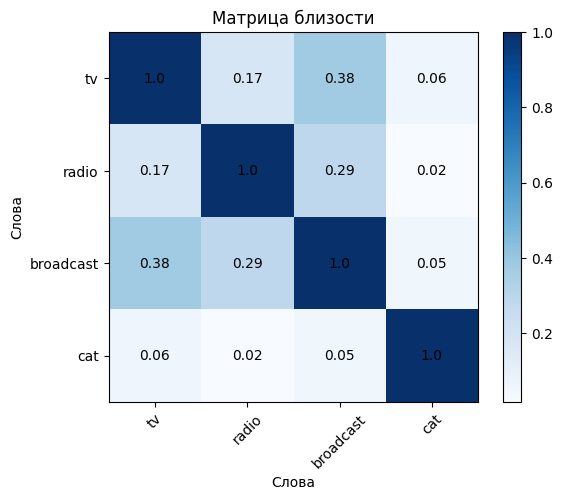

In [26]:
check_doesnt_match_results(
    model=model_word2vec, words=["tv", "radio", "broadcast", "cat"]
)

По выводу функции doesnt_match мы получили, что слово cat в списке ['tv', 'radio', 'broadcast', 'cat'] лишнее. Если для каждой пары слов рассчитать косинусную близость, то можно увидеть, что для слова cat косинусная близость с другими словами самая маленькая

Сделаем то же самое для FastText

In [20]:
%%time
model_fasttext = FastText(
    sentences=X_train_words,
    vector_size=300,  # default = 100
    window=10,  # default = 5
    min_count=10,
    sg=1,  # Training algorithm: 1 for skip-gram; otherwise CBOW
    hs=0,  #  If 1, hierarchical softmax will be used for model training. If 0, and negative is non-zero, negative sampling will be used.
    negative=2,  # If > 0, negative sampling will be used, if set to 0, no negative sampling is used.
    epochs=20,  # Number of iterations (epochs) over the corpus
    seed=RANDOM_SEED,
)

CPU times: user 3min 58s, sys: 933 ms, total: 3min 59s
Wall time: 1min 25s


Посмотрим на внутреннюю оценку

In [21]:
check_similar_words_results(model=model_fasttext, initial_word="game")

Пара game - gamer
Косинусная близость по модели: 0.7586571574211121
Косинусная близость по метрике из sklearn 0.7586571574211121

Пара game - gambl
Косинусная близость по модели: 0.5320618152618408
Косинусная близость по метрике из sklearn 0.5320618152618408

Пара game - uwe
Косинусная близость по модели: 0.43684807419776917
Косинусная близость по метрике из sklearn 0.4368480145931244

Пара game - gabriel
Косинусная близость по модели: 0.36090314388275146
Косинусная близость по метрике из sklearn 0.3609030842781067

Пара game - fame
Косинусная близость по модели: 0.36083704233169556
Косинусная близость по метрике из sklearn 0.36083701252937317



Вывод функции doesnt_match: cat


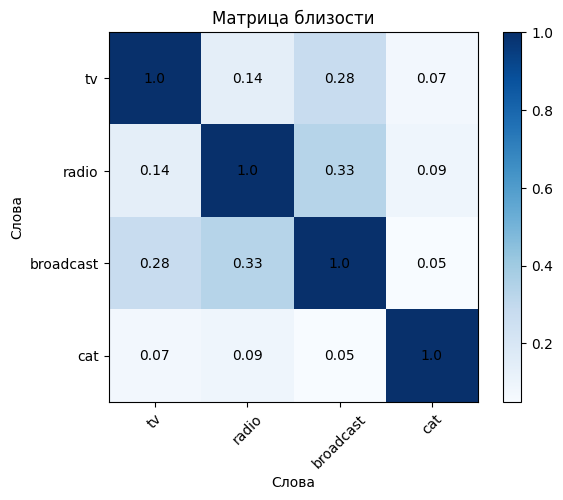

In [27]:
check_doesnt_match_results(
    model=model_fasttext, words=["tv", "radio", "broadcast", "cat"]
)

Вывод по внутренней оценке аналогичен выводу для модели Word2Vec, только что значения косинусной близости получились другие для пар слов и функиця most_similar выдает другой результат

### Обучим логистическую регрессию на векторах каждой модели

In [23]:
def avg_vector_model(sentences: list[str], model: Word2Vec) -> np.ndarray:
    """Вычисляет усредненный эмбеддинг для каждого предложения текста."""
    transformed = []
    for idx, sentence in sentences.items():
        valid_words = [
            word for word in sentence.split() if word in list(model.wv.index_to_key)
        ]
        if valid_words:
            embedding = np.zeros((len(valid_words), 300), dtype=np.float32)
            for idx, word in enumerate(valid_words):
                embedding[idx] = model.wv[word]
            transformed.append(np.mean(embedding, axis=0))
        else:
            transformed.append(np.zeros(300))
    return np.asarray(transformed)

In [24]:
def train_logistic_regression(
    X_train: np.ndarray, X_test: np.ndarray, y_train: np.ndarray, model: Word2Vec
) -> np.ndarray:
    """Обучает логистическую регрессую на наборе эмбеддингов, полученнных на основе векторной модели."""
    x_train_transformed = avg_vector_model(X_train, model)
    x_test_transformed = avg_vector_model(X_test, model)
    lr_model = LogisticRegression(random_state=RANDOM_SEED)
    lr_model.fit(x_train_transformed, y_train)
    return lr_model.predict(x_test_transformed)

In [25]:
for model in (model_word2vec, model_fasttext):
    y_pred = train_logistic_regression(X_train, X_test, y_train.to_numpy(), model)
    print(f"Модель: {model.__class__.__name__}")
    print(classification_report(y_test, y_pred))

Модель: Word2Vec
              precision    recall  f1-score   support

           0       0.88      0.86      0.87       419
           1       0.85      0.87      0.86       381

    accuracy                           0.86       800
   macro avg       0.86      0.87      0.86       800
weighted avg       0.87      0.86      0.87       800

Модель: FastText
              precision    recall  f1-score   support

           0       0.87      0.86      0.87       419
           1       0.85      0.86      0.85       381

    accuracy                           0.86       800
   macro avg       0.86      0.86      0.86       800
weighted avg       0.86      0.86      0.86       800



Вывод: без подбора гиперпараметров метрики моделей Word2Vec и FastText получились почти одинаковыми. Метрики Word2Vec выше на 1 процент, чем метрики FastText